## Load libraries

In [1]:
from detectron2.config import get_cfg
from detectron2 import model_zoo 
from detectron2.engine import DefaultPredictor
import os
from pathlib import Path
import cv2
from matplotlib import pyplot as plt
from detectron2.utils.visualizer import Visualizer
from matplotlib import pyplot as plt
from detectron2.data.datasets import register_pascal_voc
from detectron2.data.catalog import MetadataCatalog
from detectron2.structures import Boxes

In [ ]:
imgs_path = ''

## Configurations

In [2]:
import random
from tqdm import tqdm

def inference_pipeline(path_file, path_out):
    
    os.makedirs(path_out, exist_ok=True)
    
    print('Imagenes with no classes found will be deteled')
    print("Some samples will be show")

    _count = 0
    _removed = 0
    _labeled = 0
    path_file = Path(path_file)
    files = path_file.iterdir()
    for file in tqdm(files):
        name_file = file.stem        
        im = cv2.imread(str(file))
        outputs = predictor(im)
        
        
        bbxs = _convert_boxes(outputs["instances"].to("cpu").pred_boxes)        
        num_pred = len(outputs["instances"].pred_boxes)
        
        if num_pred <= 0:
            os.remove(str(file))
            _removed += 1
            
        else:
            write_file(bbxs, '/'+name_file, path_out)
            if _count < 3:
                v = Visualizer(im[:, :, ::-1],
                        metadata=ds_metadata
                         )
                out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
                plt.imshow(cv2.cvtColor(
                    out.get_image()[:, :, ::-1], 
                    cv2.COLOR_BGR2RGB))
                plt.show()
            _labeled += 1
        _count +=1
            
    print(_removed, "images removed")
    print(_labeled, "images labeled")
def _convert_boxes(boxes):
        """
        Convert different format of boxes to an NxB array, where B = 4 or 5 is the box dimension.
        """
        if isinstance(boxes, Boxes) or isinstance(boxes, RotatedBoxes):
            return boxes.tensor.numpy()
        else:
            return np.asarray(boxes)
        
def write_file(bbxs, name_file, path_out):
    where = path_out + name_file +'.txt'
    with open(path_out + name_file +'.txt', 'w') as f:
        for bbx in bbxs:
            x1 = str(float(bbx[0]))
            x2 = str(float(bbx[1]))
            x3 = str(float(bbx[2]))
            x4 = str(float(bbx[3]))
            
            f.write(CLASS_NAMES[0]+' ' + x1+' ' + x2+' ' + x3+' ' + x4+'\n')

In [3]:
network = 'faster_rcnn_R_50_FPN_3x.yaml' # must be the same than model trained
CLASS_NAMES = ['Deformation']

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/"+network))
cfg.OUTPUT_DIR = 'LAST_faster_rcnn_R_50_FPN_3x.yaml'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0000999.pth")  # path to the model we just trained

In [6]:
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold

In [7]:
predictor = DefaultPredictor(cfg)

In [8]:
# Information for label correctly the inferences

ds_metadata = MetadataCatalog.get('train_ds')
ds_metadata.dirname = '../DATAS/voc.data'
ds_metadata.split='train'
ds_metadata.thing_classes=CLASS_NAMES
ds_metadata.year=None

## Genetare Labels

In [9]:
import numpy as np
import argparse
import fileinput

In [10]:
data_in = '../DATAS/test' # datas where make the inference
data_out = cfg.OUTPUT_DIR+'/Annotations' # Where save the inferecnes

0it [00:00, ?it/s]

Imagenes with no classes found will be deteled
Some samples will be show


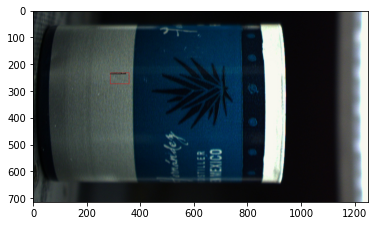

1it [00:00,  2.22it/s]

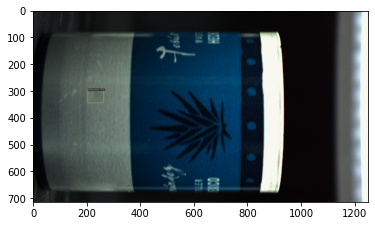

2it [00:00,  2.28it/s]

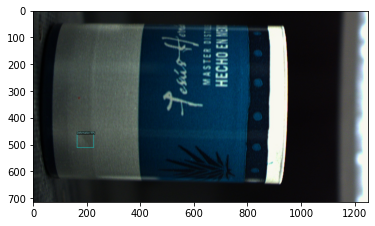

4850it [14:02,  5.75it/s]

3467 images removed
1383 images labeled


In [28]:
inference_pipeline(data_in, data_out)

## Convert txts to Yolo

In [11]:
!

In [29]:
base_project = '/home/mjack3/Documentos/projects/IO_13_TORRENT_MACA' # ROOT TO THE PROJECT DIRECTORY

In [30]:
# function that turns XMin, YMin, XMax, YMax coordinates to normalized yolo format
def convert(filepath_str, coords):
    os.chdir("..")
    image = cv2.imread(filepath_str + ".jpg")
    coords[2] -= coords[0]
    coords[3] -= coords[1]
    x_diff = int(coords[2]/2)
    y_diff = int(coords[3]/2)
    coords[0] = coords[0]+x_diff
    coords[1] = coords[1]+y_diff
    coords[0] /= int(image.shape[1])
    coords[1] /= int(image.shape[0])
    coords[2] /= int(image.shape[1])
    coords[3] /= int(image.shape[0])
    os.chdir("Label")
    return coords

In [34]:
# create dict to map class names to numbers for yolo

classes = {}
os.makedirs(network+'/YOLO/Dataset/train/'+CLASS_NAMES[0]+'/Label', exist_ok=True) # All the new annotated images will be used for training
# os.makedirs(network+'/OID/Dataset/test/'+CLASS_NAMES[0]+'/Label', exist_ok=True) 

In [35]:
# Write classes.txt
with open(network+'/YOLO/Dataset/train/'+CLASS_NAMES[0]+'/classes.txt', 'w') as myFile:
    myFile.write(CLASS_NAMES[0])
    
# Read
with open(network+'/YOLO/Dataset/train/'+CLASS_NAMES[0]+'/classes.txt', 'r') as myFile:
    for num, line in enumerate(myFile, 0):
        line = line.rstrip("\n")
        classes[line] = num
    myFile.close()

In [36]:
# Copy the images and labels

from shutil import copyfile

path_file = Path(data_in)
path_ann = Path(data_out)
files = list(path_file.iterdir())
anns = list(path_ann.iterdir())

total = 0

for f in files:
    name = f.stem
    suffix = f.suffix
    copyfile(str(f), network+'/YOLO/Dataset/train/'+CLASS_NAMES[0]+'/'+name+suffix)
    total += 1
print(total, "imagenes copied to OID directory")
    
total = 0
for a in anns:
    name = a.stem
    suffix = a.suffix
    copyfile(str(a), network+'/YOLO/Dataset/train/'+CLASS_NAMES[0]+'/Label/'+name+suffix)
    total += 1
print(total, "annotations copied OID directory")

1383 imagenes copied to OID directory
1383 annotations copied OID directory


In [37]:
# step into dataset directory
os.chdir(os.path.join(network, "YOLO", "Dataset"))
DIRS = os.listdir(os.getcwd())

In [41]:
print('map of classes: {} amd directories founded: {}'.format(classes, DIRS))

map of classes: {'Deformation': 0} amd directories founded: ['train']


In [42]:
# for all train, validation and test folders
for DIR in DIRS:
    if os.path.isdir(DIR):
        os.chdir(DIR)
        print("Currently in subdirectory:", DIR)
        
        CLASS_DIRS = os.listdir(os.getcwd())
        # for all class folders step into directory to change annotations
        for CLASS_DIR in CLASS_DIRS:
            if os.path.isdir(CLASS_DIR):
                os.chdir(CLASS_DIR)
                print("Converting annotations for class: ", CLASS_DIR)
                
                # Step into Label folder where annotations are generated
                os.chdir("Label")
                
                for filename in tqdm(os.listdir(os.getcwd())):
                    filename_str = str.split(filename, ".")[0]
                    if filename.endswith(".txt"):
                        annotations = []
                        with open(filename) as f:
                            for line in f:
                                for class_type in classes:
                                    line = line.replace(class_type, str(classes.get(class_type)))
                                labels = line.split()
                                coords = np.asarray([float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])])
                                coords = convert(filename_str, coords)
                                labels[1], labels[2], labels[3], labels[4] = coords[0], coords[1], coords[2], coords[3]
                                newline = str(labels[0]) + " " + str(labels[1]) + " " + str(labels[2]) + " " + str(labels[3]) + " " + str(labels[4])
                                line = line.replace(line, newline)
                                annotations.append(line)
                            f.close()
                        os.chdir("..")
                        with open(filename, "w") as outfile:
                            for line in annotations:
                                outfile.write(line)
                                outfile.write("\n")
                            outfile.close()
                        os.chdir("Label")
                os.chdir("..")
                os.chdir("..")
        os.chdir("..")

  1%|          | 7/1383 [00:00<00:20, 68.11it/s]

Currently in subdirectory: train
Converting annotations for class:  Deformation


100%|██████████| 1383/1383 [00:14<00:00, 94.90it/s] 


In [21]:
!pwd

/home/mjack3/Documentos/projects/IO_13_TORRENT_MACA/CODE/faster_rcnn_R_101_FPN_3x.yaml/YOLO/Dataset
